In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns




In [18]:
data = pd.read_csv("onlinefraud .csv")
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [19]:
# Remove isFlaggedFraud column
data.drop(columns=['isFlaggedFraud'], inplace=True)


In [20]:
data.shape


(6362620, 10)

In [35]:
print(data.isnull().sum())

step                          0
type                          0
amount                        0
nameOrig                      0
oldbalanceOrg                 0
newbalanceOrig                0
nameDest                      0
oldbalanceDest                0
newbalanceDest                0
isFraud                       0
amount_to_oldbalanceOrg       0
amount_to_newbalanceOrig      0
balance_change_ratio_orig     0
balance_change_ratio_dest     0
transaction_freq_orig         0
transaction_freq_dest         0
avg_amount_orig               0
avg_amount_dest               0
amount_to_avg_orig           16
amount_to_avg_dest            3
hour                          0
is_night                      0
dtype: int64


In [22]:
print(data.type.value_counts())

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [23]:
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
print(data.head())


   step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     2   9839.64  C1231006815       170136.0       160296.36   
1     1     2   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     2  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155             0.0             0.0        0  
1  M2044282225             0.0             0.0        0  
2   C553264065             0.0             0.0        1  
3    C38997010         21182.0             0.0        1  
4  M1230701703             0.0             0.0        0  


In [24]:
# Analyze fraud distribution
print(data['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


Feature Engineer

In [25]:
def engineer_features(df):
    # Transaction amount relative to account balance
    df['amount_to_oldbalanceOrg'] = df['amount'] / (df['oldbalanceOrg'] + 1)
    df['amount_to_newbalanceOrig'] = df['amount'] / (df['newbalanceOrig'] + 1)
    
    # Balance change ratio
    df['balance_change_ratio_orig'] = (df['newbalanceOrig'] - df['oldbalanceOrg']) / (df['oldbalanceOrg'] + 1)
    df['balance_change_ratio_dest'] = (df['newbalanceDest'] - df['oldbalanceDest']) / (df['oldbalanceDest'] + 1)
    
    # Transaction frequency features
    df['transaction_freq_orig'] = df.groupby('nameOrig')['step'].transform('count')
    df['transaction_freq_dest'] = df.groupby('nameDest')['step'].transform('count')
    
    # Average transaction amount
    df['avg_amount_orig'] = df.groupby('nameOrig')['amount'].transform('mean')
    df['avg_amount_dest'] = df.groupby('nameDest')['amount'].transform('mean')
    
    # Amount relative to average
    df['amount_to_avg_orig'] = df['amount'] / df['avg_amount_orig']
    df['amount_to_avg_dest'] = df['amount'] / df['avg_amount_dest']
    
    # Time-based features
    df['hour'] = df['step'] % 24
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    
    return df


In [ ]:
df["amount_to_oldbalanceOrg"]

In [26]:
# Apply feature engineering
data_engineered = engineer_features(data)


In [27]:
# Drop rows with missing values
data_cleaned = data_engineered.dropna()


In [28]:
print(f"Rows dropped: {len(data_engineered) - len(data_cleaned)}")

Rows dropped: 16


In [46]:
data_cleaned

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,balance_change_ratio_orig,balance_change_ratio_dest,transaction_freq_orig,transaction_freq_dest,avg_amount_orig,avg_amount_dest,amount_to_avg_orig,amount_to_avg_dest,hour,is_night
0,1,2,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,...,-0.057834,0.000000,1,1,9839.64,9.839640e+03,1.0,1.000000,1,1
1,1,2,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,...,-0.087731,0.000000,1,1,1864.28,1.864280e+03,1.0,1.000000,1,1
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,...,-0.994505,0.000000,1,44,181.00,2.255178e+05,1.0,0.000803,1,1
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,...,-0.994505,-0.999953,1,41,181.00,4.394442e+05,1.0,0.000412,1,1
4,1,2,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,...,-0.280788,0.000000,1,1,11668.14,1.166814e+04,1.0,1.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,...,-0.999997,339682.130000,1,2,339682.13,3.323914e+05,1.0,1.021934,23,1
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,...,-1.000000,0.000000,1,1,6311409.28,6.311409e+06,1.0,1.000000,23,1
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,...,-1.000000,92.151030,1,3,6311409.28,2.212471e+06,1.0,2.852652,23,1
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,...,-0.999999,0.000000,1,1,850002.52,8.500025e+05,1.0,1.000000,23,1


In [ ]:
pd.set_option

In [36]:
# Prepare features and target
X = data_cleaned.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = data_cleaned['isFraud']


In [38]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [39]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [40]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [41]:
# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]


In [42]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       0.99      0.81      0.89      1639

    accuracy                           1.00   1272521
   macro avg       0.99      0.90      0.94   1272521
weighted avg       1.00      1.00      1.00   1272521


Confusion Matrix:
[[1270866      16]
 [    317    1322]]

ROC AUC Score:
0.9974470939529462


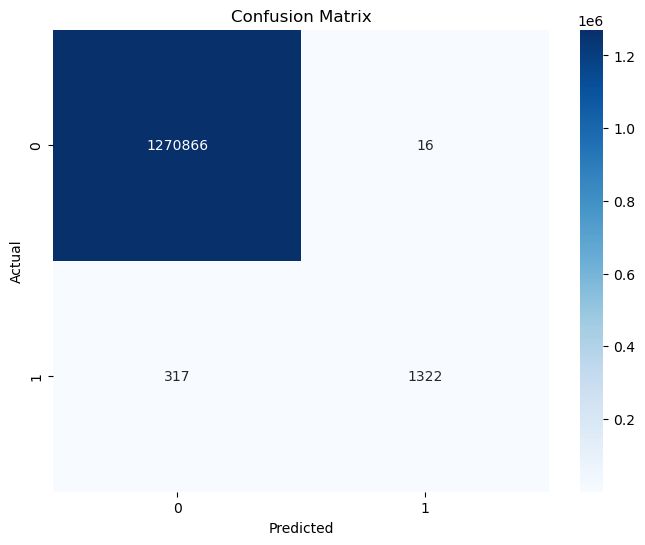

In [43]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)


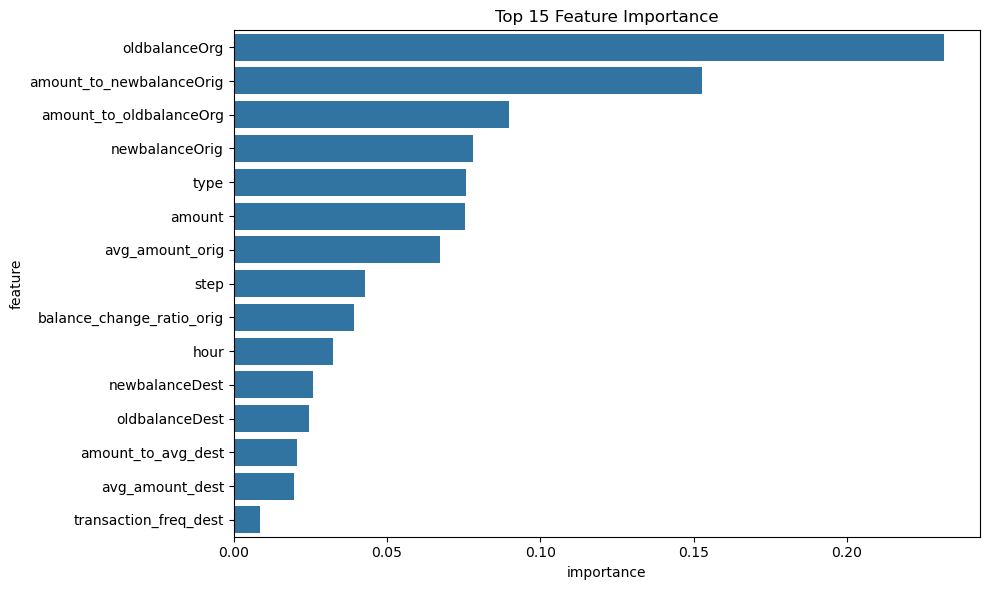

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()